### Digit Recognizer:

You can find the details on:  https://www.kaggle.com/competitions/digit-recognizer

> Competition Description
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.
In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

For this problem, we will use deep learning techniques to delve into computer vision. I will give a detailed explanation of the code and in the end I will give you what I achieved in the public score.


One important note: We will use GPU for the calculations since CPU will take a lot of time. In Kaggle or Google Colab, you can use GPU's. In Kaggle, you have 30 hours per week, on the other hand in Colab, the time is not certain. I suggest you to use Kaggle unless you are professional.

We will import the necessary librariers. We will use tensorflow-keras for this problem. We will read the data from csv with pandas library. Seaborn-matplotlib will be used for drawing graphs.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import keras

from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models, optimizers, preprocessing, regularizers

We read the data by using pandas. I used this code in Kaggle. So, you should be able ro repeat this process there. You can also work with this code locally by changing the folder's name below.


In [ ]:
#
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


#We can check the size of the data
print(train_df.shape)
print(test_df.shape)

(42000, 785)
(28000, 784)


An example for the given data. As you see, the features are "pixels". You can use "head" to see the first five entries of the dataframe.


In [ ]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We scale the given numbers. Why? You can check the following stackoverflow webpage:

"https://stackoverflow.com/questions/20486700/why-do-we-always-divide-rgb-values-by-255#:~:text=It%20really%20comes%20down%20to,255%20since%200%20is%20included."

The best explanation:

> RGB (Red, Green, Blue) are 8 bit each.
The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
The combination range is 256*256*256. By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).

In [ ]:
X_train_full = train_df.to_numpy()[:, 1:].reshape(len(train_df), 28, 28, 1)
X_train_full = X_train_full / 255.0
print(X_train_full.shape)

y_train_full = train_df.to_numpy()[:, 0]
print(y_train_full.shape)

# We split the data into tranining and validation set.
# We can shuffle the data. The data may be given you in a biased form. Shuffling makes sense. Shuffle is default true.
# There is also Stratify option. You can chek at https://scikit-learn.org/dev/modules/cross_validation.html#stratification

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


# And test set of course
X_test = test_df.to_numpy().reshape(len(test_df), 28, 28, 1)
X_test = X_test / 255.0
print(X_test.shape)

(42000, 28, 28, 1)
(42000,)
(33600, 28, 28, 1)
(33600,)
(8400, 28, 28, 1)
(8400,)
(28000, 28, 28, 1)


Using matplotlib-seaborn to check some of the given handwritten integers. You can play with the given numbers.

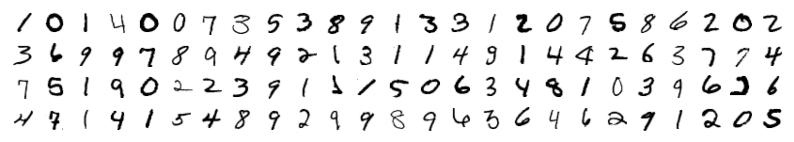

In [ ]:

fig = plt.figure(figsize=(10,1.6))
for i in range(100):
    ax = plt.subplot(4, 25, i + 1)
    ax.axis('off')
    plt.imshow(np.array(train_df.iloc[i,1:]).reshape((28,28)), cmap='gray_r')

The following code is for preparing the given data. Some options are:
* rotation_range
* zoom_range
* width_shift_range
* height_shift_range
* shear_range
* interpolation_order

and other possiblities. Be careful with these options: If you set them large numbers, the method may fail learn from the data and you will have worse results. So, play with the numbers to compare the results with given small neural networks.
You can find the options from keras' website.

In [ ]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=5,
    interpolation_order=3,
)
datagen.fit(X_train)

We will focus on the learning rate. You can find on: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
> tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=False,
    name='ExponentialDecay'
)

The learning rate is important for the neural networks. Brief descriptions about the hyperparameters can be found at:

https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-llms-finetuning-hyperparameters.html

In [ ]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=255,
    decay_rate=0.91
)

We will construct the Deep Learning model. There are different layers. This method is called CNN: Convolutional Neural Network. Basic explanations of codes for CIFAR data can be found at:

https://www.tensorflow.org/tutorials/images/cnn

A basic explanation of CNN can be found at:

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939


In short:

Conv2D:
> This layer performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is the restricted portion of the receptive field. The kernel is spatially smaller than an image but is more in-depth. This means that, if the image is composed of three (RGB) channels, the kernel height and width will be spatially small, but the depth extends up to all three channels.

Activation: We have functions like: Sigmoid, tanh, ReLU, etc. Each one of them can be used, however there may be vanishing gradient problem coming from sigmoid and tanh functions while using gradient descent algorithm in neural networks. (https://en.wikipedia.org/wiki/Vanishing_gradient_problem). In general people are using ReLU or Leaky ReLU.

Dropout and Regularization: These are to prevent "overfitting". If you train your training data so "good", the method will not be able to predict the validation set's results. To prevent that, you can utilize these methods. You can find some information at https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

MaxPolling2D: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
> The pooling layer replaces the output of the network at certain locations by deriving a summary statistic of the nearby outputs. This helps in reducing the spatial size of the representation, which decreases the required amount of computation and weights.

Flatten: https://www.educative.io/answers/what-is-a-neural-network-flatten-layer

> The flatten layer is a component of the convolutional neural networks (CNN's). A complete convolutional neural network can be broken down into two parts:
CNN: The convolutional neural network that comprises the convolutional layers.
ANN: The artificial neural network that comprises dense layers.
The flatten layer lies between the CNN and the ANN, and its job is to convert the output of the CNN into an input that the ANN can process


In [ ]:
# For this question, we don't need to use dropout and/or regularization. The data is so nice that, we don't overfit easily.
# In case we have overfitting,
# we should use dropout or/and regularization

DROPOUT = 0.0
REG = 0.00
model = models.Sequential([
    layers.Input((28, 28, 1), name="In"),

    # 28 X 28
    layers.Conv2D(256, (3, 3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.L2(REG), name='C1'),
    layers.BatchNormalization(name='B1'),
    layers.Activation('relu', name='A1'),
    layers.Dropout(DROPOUT, name='D1'),

    layers.MaxPooling2D((2, 2), name='P1'),

    # 14 X 14
    layers.Conv2D(512, (3, 3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.L2(REG), name='C2'),
    layers.BatchNormalization(name='B2'),
    layers.Activation('relu', name='A2'),
    layers.Dropout(DROPOUT, name='D2'),

    layers.MaxPooling2D((2, 2), name='P2'),

    # 7 X 7
    layers.Conv2D(1024, (3, 3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.L2(REG), name='C3'),
    layers.BatchNormalization(name='B3'),
    layers.Activation('relu', name='A3'),
    layers.Dropout(DROPOUT, name='D3'),

    # This is where you'd normally see some Dense layers. You may not use them.
    layers.Dense(128, activation='relu'),

    layers.Flatten(),
    layers.Dense(10, activation='linear', name='Out'),

])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 256)    │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ B1 (BatchNormalization)         │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ A1 (Activation)                 │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D1 (Dropout)                    │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P1 (MaxPooling2D)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C2 (Conv2D)                     │ (None, 14, 14, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ B2 (BatchNormalization)         │ (None, 14, 14, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ A2 (Activation)                 │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D2 (Dropout)                    │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P2 (MaxPooling2D)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 7, 7, 1024)     │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ B3 (BatchNormalization)         │ (None, 7, 7, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ A3 (Activation)                 │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ D3 (Dropout)                    │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Out (Dense)                     │ (None, 10)             │        62,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,101,642 (23.28 MB)

 Trainable params: 6,098,058 (23.26 MB)

 Non-trainable params: 3,584 (14.00 KB)

We will compile and fit the method. Information about coding part can be found at: https://www.tensorflow.org/guide/keras/training_with_built_in_methods

We complie the model and then fit it with the given training data. We used sparse categorical crossentropy for validation loss, Adam optimizer for optimizer with the learning rate we gave before, and we chose the metric as "accuracy". We can choose any metric related to classification i.e., AUC, ROC, precision, etc.

Early Stopping: For fitting we used early stopping to prevent *plateauing of the validation accuracy*. In this case, the model can't predict validation set better. Hence, if you try to continue to fit, you will overfit. You need to stop there, since your method will be getting worse each epoch. I chose 10 for *patience* for the fit. This means that, if the method can't improve validation accuracy for 10 epochs, it will stop.

Epochs: That's the number of each step of learning.

Batch Size: A very good and detailed explanation can be found at AWS website: (https://aws.amazon.com/blogs/machine-learning/the-importance-of-hyperparameter-tuning-for-scaling-deep-learning-training-to-multiple-gpus/#:~:text=One%20of%20the%20leading%20theories,mini%2Dbatch%20on%20model%20quality). Basically they say 32 or 64 is good enough for this hyperparameter. Choosing larger batch size won't improve the time much.


In [ ]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(lr_schedule),
    metrics=['accuracy']
)


start = time.time()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=1000,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [callback]
)


Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1736541570.715565     101 service.cc:145] XLA service 0x79c11c004790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736541570.715630     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/525 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.2156 - loss: 2.1878

I0000 00:00:1736541575.312471     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.8919 - loss: 0.3364 - val_accuracy: 0.8949 - val_loss: 0.4056
Epoch 2/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9777 - loss: 0.0679 - val_accuracy: 0.9852 - val_loss: 0.0505
Epoch 3/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9868 - loss: 0.0453 - val_accuracy: 0.9843 - val_loss: 0.0534
Epoch 4/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9885 - loss: 0.0368 - val_accuracy: 0.9870 - val_loss: 0.0468
Epoch 5/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9909 - loss: 0.0312 - val_accuracy: 0.9918 - val_loss: 0.0286
Epoch 6/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9925 - loss: 0.0249 - val_accuracy: 0.9902 - val_loss: 0.0308
Epoch 7/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9935 - loss: 0.0205 - val_accuracy: 0.9932 - val_loss: 0.0261
Epoch 8/1000
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9933 - loss: 0.0207

The following is for the results for the accuracy of training and the validation set. You can also find them in the previous step.

In [ ]:
print('Training time:', time.time() - start, "\n")

y_hat_train = np.argmax(model.predict(X_train), axis=1)
train_accuracy = np.sum(y_hat_train == y_train)/y_train.shape[0]

y_hat_val = np.argmax(model.predict(X_val), axis=1)
val_accuracy = np.sum(y_hat_val == y_val)/y_val.shape[0]

print("\nTraining accuracy is: ", train_accuracy, "and validation accuracy is: ", val_accuracy)

Training time: 750.2503490447998 

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training accuracy is:  0.9995833333333334 and validation accuracy is:  0.9948809523809524


We can check the following whether we overfitted, underfitted,or not. We can also check the "plateaued" validation loss or accuracy.

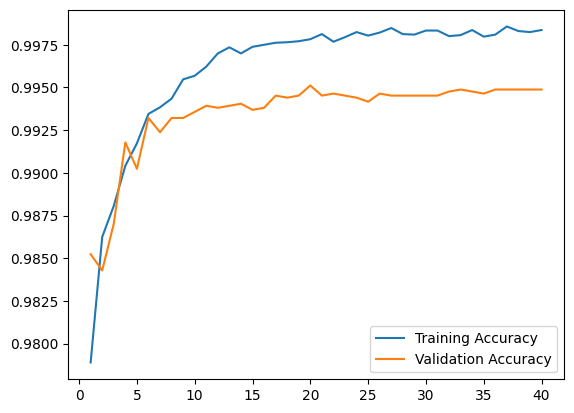

In [ ]:
num_epochs = len(history.history['loss'])
plt.plot(list(range(1,num_epochs)), history.history['accuracy'][1:], label="Training Accuracy")
plt.plot(list(range(1,num_epochs)), history.history['val_accuracy'][1:], label='Validation Accuracy')
_ = plt.legend()

The following is to create the submission file for Kaggle competition.

In [ ]:
y_hat_test = np.argmax(model.predict(X_test), axis=1)
with open('submission.csv', 'w') as f:
    f.write('ImageId,Label\n')
    for i in range(len(y_hat_test)):
        f.write(str(i + 1) + ',' + str(y_hat_test[i]) + '\n')

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


### Result

I used different version of paramaters and hyperparameters here to show how the code works. By using my hyperparameters I obtained: The public result: 0.99571 and the place 80/1685. With this code, you will have 99.446 as a public score.

### References:
* https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-llms-finetuning-hyperparameters.html
* https://stackoverflow.com/questions/20486700/why-do-we-always-divide-rgb-values-by-255#:~:text=It%20really%20comes%20down%20to,255%20since%200%20is%20included
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay
* https://www.tensorflow.org/tutorials/images/cnn
* https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
* https://www.educative.io/answers/what-is-a-neural-network-flatten-layer
* https://www.tensorflow.org/guide/keras/training_with_built_in_methods
* https://aws.amazon.com/blogs/machine-learning/the-importance-of-hyperparameter-tuning-for-scaling-deep-learning-training-to-multiple-gpus/#:~:text=One%20of%20the%20leading%20theories,mini%2Dbatch%20on%20model%20quality